In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
# from tabulate import tabulate
import re
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
tempos = ["010", "020", "030"]
tempoEstavel = 100
seeds = ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150"]
# seeds = ["10", "20"]
quantidadeIperfs = 2500
salvarGraficos = True
#Tabela tempo->medicao
#010 -> 100=18 250=48
#020 -> 150=28 300=58
#030 -> 200=38 350=68
#intervalosEstaveis = [("010", 18, 48), ("020", 28, 58), ("030", 38, 68)]
intervalosEstaveis = [("010", 28, 48), ("020", 38, 58), ("030", 48, 68)]
intervalosTempo = [("010", 150, 250), ("020", 200, 300), ("030", 250, 350)]
confianca = 99

In [3]:
#Adicionando colunas com a medicao
mHW = 0
mSW = 0
def teste (nomeSwitch):
    global mHW
    global mSW
    if (nomeSwitch == "HW"):
        mHW += 1
        return mHW
    if (nomeSwitch == "SW"):
        mSW += 1
        return mSW

#Lendo os arquivos info (report do controlador)
dfPI_info = pd.DataFrame()
dfSW_info = pd.DataFrame()
i = 1
for seed in seeds:
    mHW = 0
    mSW = 0
    for tempo in tempos:
        mHW = 0
        mSW = 0
        dfPI_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_infoTemp['TempoChegada'] = tempo
        dfPI_infoTemp['Seed'] = seed
        dfPI_infoTemp['Política'] = 'Estática'
        dfPI_infoTemp['Medicao'] = dfPI_infoTemp['Switch'].apply(teste)
        dfPI_info = pd.concat([dfPI_info, dfPI_infoTemp], ignore_index=True)
        mHW = 0
        mSW = 0
        dfSW_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_infoTemp['TempoChegada'] = tempo
        dfSW_infoTemp['Seed'] = seed
        dfSW_infoTemp['Política'] = 'Dinâmica'
        dfSW_infoTemp['Medicao'] = dfSW_infoTemp['Switch'].apply(teste)
        dfSW_infoTemp.rename(columns={'VezesBloqueado':'RegrasBloqueadas'}, inplace=True)
        dfSW_info = pd.concat([dfSW_info, dfSW_infoTemp], ignore_index=True)
    i += 1
dfTotal_info = pd.concat([dfPI_info, dfSW_info], ignore_index=True)
dfTotal_info.to_csv(r'pandas.txt', index=None, sep=' ', mode='a')

In [4]:
def teste(g):
    g['teste'] = "ok"
    return g
#Trafego em cada switch no intervalo estavel
#inicio = 18
#display(dfTotal_info.query("Medicao >= @inicio and Medicao <= 48"))
gpb = dfTotal_info.groupby(["Política", "TempoChegada", "Switch", "Medicao", "Seed"]).apply(teste)
gpb['Total'] = 0
gpb.reset_index(inplace=True)
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and (row['Medicao'] != b and row['Medicao'] != c)):
            gpb.drop(index, inplace=True)
display(gpb)

,index,Tempo,Switch,RegrasInstaladas,RegrasAceitas,RegrasBloqueadas,BytesEnviados,TempoChegada,Seed,Política,Medicao,teste,Total
54,54,146,HW,198,585,398,1438279416,010,10,Estática,28,ok,0
55,55,146,SW,404,1169,0,2258776548,010,10,Estática,28,ok,0
94,94,247,HW,190,980,788,3261182904,010,10,Estática,48,ok,0
95,95,249,SW,394,2227,0,5953541772,010,10,Estática,48,ok,0
218,218,200,HW,192,745,46,1644278832,020,10,Estática,38,ok,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21932,21932,298,SW,284,2749,0,2061918252,020,150,Dinâmica,58,ok,0
22152,22152,245,HW,160,1156,0,2497235832,030,150,Dinâmica,48,ok,0
22153,22153,247,SW,155,1500,0,817781820,030,150,Dinâmica,48,ok,0
22192,22192,347,HW,156,1600,0,4274939592,030,150,Dinâmica,68,ok,0


In [5]:
#Calculando o total transmitido no intervalo estavel
#(bytesenviados no fim-inicio porque bytesenviados é acumulativo)
totalHW = 0
totalSW = 0
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "HW"):
            totalHW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "HW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalHW
            totalHW = 0
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "SW"):
            totalSW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "SW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalSW
            totalSW = 0
gpb = gpb[gpb.Total != 0]
display(gpb)

,index,Tempo,Switch,RegrasInstaladas,RegrasAceitas,RegrasBloqueadas,BytesEnviados,TempoChegada,Seed,Política,Medicao,teste,Total
94,94,247,HW,190,980,788,3261182904,010,10,Estática,48,ok,1822903488
95,95,249,SW,394,2227,0,5953541772,010,10,Estática,48,ok,3694765224
258,258,301,HW,190,1191,88,3337307568,020,10,Estática,58,ok,1693028736
259,259,301,SW,212,1363,0,3880701720,020,10,Estática,58,ok,1868715204
522,522,351,HW,148,1052,0,2985738840,030,10,Estática,68,ok,1317887928
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21766,21766,258,SW,729,4520,0,5680549992,010,150,Dinâmica,48,ok,3371964900
21931,21931,295,HW,173,1242,0,4965095016,020,150,Dinâmica,58,ok,2469316752
21932,21932,298,SW,284,2749,0,2061918252,020,150,Dinâmica,58,ok,851456484
22192,22192,347,HW,156,1600,0,4274939592,030,150,Dinâmica,68,ok,1777703760


In [6]:
gpb["MbSeg"] = gpb["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb["NomeSwitch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "High", "020": "Medium", "030": "Low"})
gpb["Política"] = gpb["Política"].map({"Estática": "Static", "Dinâmica": "Dynamic"})

In [7]:
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0, "legend.title_fontsize": 14.5}
sns.set (style="whitegrid", font_scale=1.35, rc=myrcs)

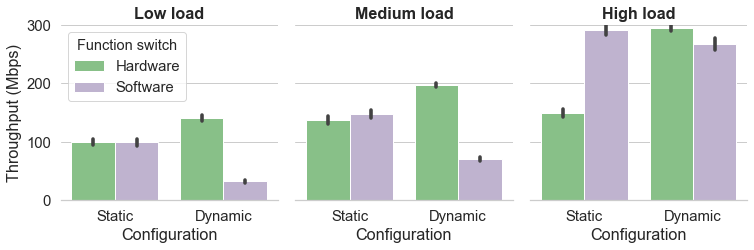

In [8]:
snsplt = sns.catplot( palette="Accent", x="Política", y="MbSeg", kind="bar",  height=3.5, aspect=1, legend_out=False, ci=99,
                      data=gpb, col="NomeTempo", hue="NomeSwitch", col_order=["Low", "Medium", "High"], order=["Static", "Dynamic"])
snsplt.set_titles("{col_name} load")
snsplt.set_axis_labels("Configuration", "Throughput (Mbps)")
snsplt._legend.set_title("Function switch")
# snsplt.axes[0,0]._legend(loc="upper left")
# leg.set_bbox_to_anchor([0.2, 0.3])
snsplt.set(ylim=(0,300))
# snsplt.set_xticklabels(rotation=45, size=12)
# snsplt.fig.set_size_inches(11,4)
order = [0, 1]
handles, labels = snsplt.axes[0, 0].get_legend_handles_labels()
snsplt.axes[0, 0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper left", title="Function switch")

snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Graficos/SBRC-VazaoMediaIntervaloEstavelPorSwitch.pdf")

In [9]:
gpb = dfTotal_info.groupby(["Seed", "TempoChegada", "Política"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(quantidadeIperfs)
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "High", "020": "Medium", "030": "Low"})

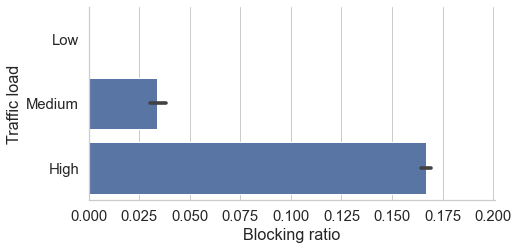

In [11]:
#Grafico de bloqueados metodo par impar

sns_plt = sns.catplot(legend=False, height=3.5, aspect=2, x="TaxaBloqueio", y="NomeTempo", kind="bar", orient="h", hue="Política", hue_order=["Estática"],order=["Low", "Medium", "High"], ci=confianca, data=gpb)
#sns_plt.fig.suptitle('Taxa de bloqueio por carga', y=1.05)
sns_plt.set(xlim=(0, 0.201))
sns_plt.set_axis_labels("Blocking ratio","Traffic load")
# sns_plt.despine(left=True)
if (salvarGraficos):
    sns_plt.savefig("Graficos/SBRC-TaxaBloqueio.pdf")